In [74]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8
import os
os.chdir(os.path.expanduser("~")+'/cmap')
model, preprocess = create_model_from_pretrained('ViT-B-16-SigLIP', pretrained='./ViT-B-16-SigLIP/open_clip_pytorch_model.bin')
tokenizer = get_tokenizer('ViT-B-16-SigLIP')

In [85]:
import robotathome as rh
print(rh.__version__)
import pandas as pd
import os
import matplotlib.pyplot as plt
from time import time
import numpy as np
from tqdm import tqdm
import pickle

from robotathome import RobotAtHome
from robotathome import logger, log, set_log_level
from robotathome import time_win2unixepoch, time_unixepoch2win
from robotathome import get_labeled_img, plot_labeled_img

log.set_log_level('INFO')  # SUCCESS is the default
level_no, level_name = log.get_current_log_level()
print(f'Current log level name: {level_name}')

my_rh_path = '~/cmap/dataset'
my_rgbd_path = os.path.join(my_rh_path, 'files/rgbd')
my_scene_path = os.path.join(my_rh_path, 'files/scene')
my_wspc_path = '~/cmap/dataset/result'

try: 
      rh = RobotAtHome(my_rh_path, my_rgbd_path, my_scene_path, my_wspc_path)
except:
      logger.error("Something was wrong")

2024-02-27 13:37:50.450 | SUCCESS  | robotathome.core.reader:__open_dataset:141 - Connection is established: rh.db


1.1.9
Current log level name: INFO


In [88]:
df = rh.get_sensor_observations('rgbdlsr')
df = df.sort_values("timestamp")
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
print(df[10:17])
print(df.info())

        id           timestamp  home_session_id  home_subsession_id  home_id  room_id  sensor_id sensor_name  sensor_pose_x  sensor_pose_y  sensor_pose_z  sensor_pose_yaw  sensor_pose_pitch  sensor_pose_roll
10  237019  130488627233528472                4                   0        4       40          0     HOKUYO1       0.205000       0.000000         0.3100         0.000000           0.000000           0.00000
11  129426  130488627234781717                4                   0        4       40          3      RGBD_3       0.265283       0.038000         1.0156         0.747963           0.014137          -1.54950
12  129427  130488627237771888                4                   0        4       40          2      RGBD_2       0.265085      -0.040152         1.0151        -0.759568           0.000175          -1.57376
13  129428  130488627238281917                4                   0        4       40          1      RGBD_1       0.281142      -0.001309         1.0150         0.0001

In [77]:
df = df.loc[df.sensor_name=="RGBD_1"]
df = df.reset_index(drop=True)
ids = df.id.tolist()
print(df.head())
print(df.info())

       id           timestamp  home_session_id  home_subsession_id  home_id  room_id  sensor_id sensor_name  sensor_pose_x  sensor_pose_y  sensor_pose_z  sensor_pose_yaw  sensor_pose_pitch  sensor_pose_roll
0  129422  130488627208070189                4                   0        4       40          1      RGBD_1       0.284435      -0.000897        1.01500         0.000275           0.022689          -1.57080
1  129423  130488627218090763                4                   0        4       40          1      RGBD_1       0.282821      -0.001955        1.01500         0.000496           0.022689          -1.57080
2  129425  130488627228191340                4                   0        4       40          1      RGBD_1       0.281301      -0.001098        1.01500         0.000276           0.022689          -1.57080
3  129428  130488627238281917                4                   0        4       40          1      RGBD_1       0.281142      -0.001309        1.01500         0.000189   

In [78]:
### Tester

# id = 129422
# [img_f, _] = rh.get_RGBD_files(id)
# image = Image.open(img_f)
# image = preprocess(image).unsqueeze(0)
# with torch.no_grad(), torch.cuda.amp.autocast():
#     image_features = model.encode_image(image)
# image_features /= image_features.norm(dim=-1, keepdim=True)
# print(image_features.size())

df = df[df.index % 100 == 0]
df = df.reset_index(drop=True)
ids = df.id.tolist()

In [79]:
start = time()
features = []
with torch.no_grad(), torch.cuda.amp.autocast():
    for id in tqdm(ids):
        try: 
            [img_f, _] = rh.get_RGBD_files(id)
            image = Image.open(img_f)
            image = preprocess(image).unsqueeze(0)
            image_features = model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features[0].tolist()
        except:
            image_features = [0] * 768
        features.append(image_features)
print('average time: ', (time()-start)/len(ids))
if not os.path.exists('./result'): os.makedirs('./result')
with open("./result/semi_exp_1.pkl","wb") as f:
    pickle.dump(features, f)

100%|██████████| 83/83 [00:17<00:00,  4.84it/s]

average time:  0.20680948337876653


In [80]:
with open("./result/semi_exp_1.pkl","rb") as f:
    features_ = pickle.load(f)
print('Check pkl file:', features == features_)
image_features = np.array(features)
features = pd.DataFrame(features)
print(features.head())
print(features.info())

Check pkl file: True
        0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25        26        27        28        29        30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48        49        50        51        52        53        54        55        56        57        58        59        60        61        62        63        64        65        66        67        68        69        70        71        72        73        74        75        76        77        78        79        80        81        82        83        84        85        86        87        88        89        90        91        92        93        94        95        96        9

In [81]:
labels_list = ["a shampoo", "bathroom", "a stove", "kitchen", "a television", "livingroom"]
text = tokenizer(labels_list, context_length=model.context_length)
with torch.no_grad(), torch.cuda.amp.autocast(): text_features = model.encode_text(text)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity =  image_features @ text_features.numpy().T
similarity = pd.DataFrame(similarity, columns=labels_list)
df_s = pd.concat([df, similarity], axis=1)
df_f = pd.concat([df_s, features], axis=1)

In [82]:
print(df_s.info())
print(df_f.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  83 non-null     int64  
 1   timestamp           83 non-null     int64  
 2   home_session_id     83 non-null     int64  
 3   home_subsession_id  83 non-null     int64  
 4   home_id             83 non-null     int64  
 5   room_id             83 non-null     int64  
 6   sensor_id           83 non-null     int64  
 7   sensor_name         83 non-null     object 
 8   sensor_pose_x       83 non-null     float64
 9   sensor_pose_y       83 non-null     float64
 10  sensor_pose_z       83 non-null     float64
 11  sensor_pose_yaw     83 non-null     float64
 12  sensor_pose_pitch   83 non-null     float64
 13  sensor_pose_roll    83 non-null     float64
 14  a shampoo           83 non-null     float64
 15  bathroom            83 non-null     float64
 16  a stove   

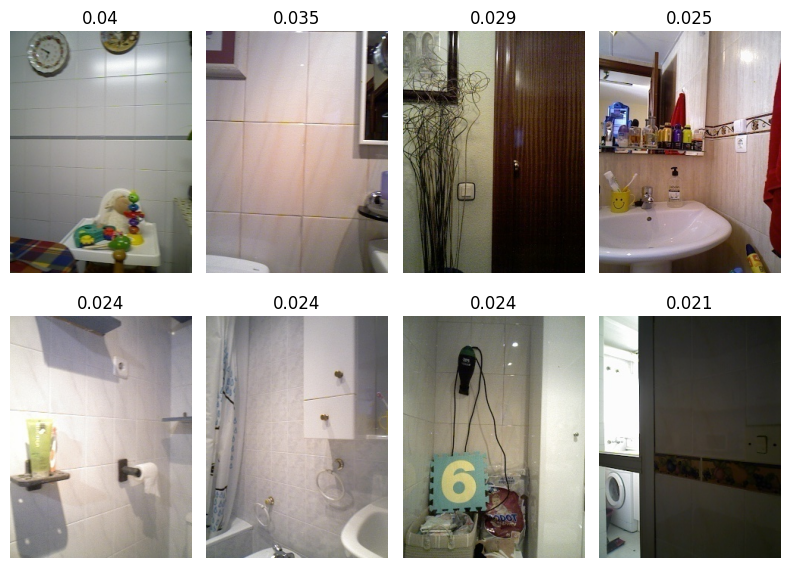

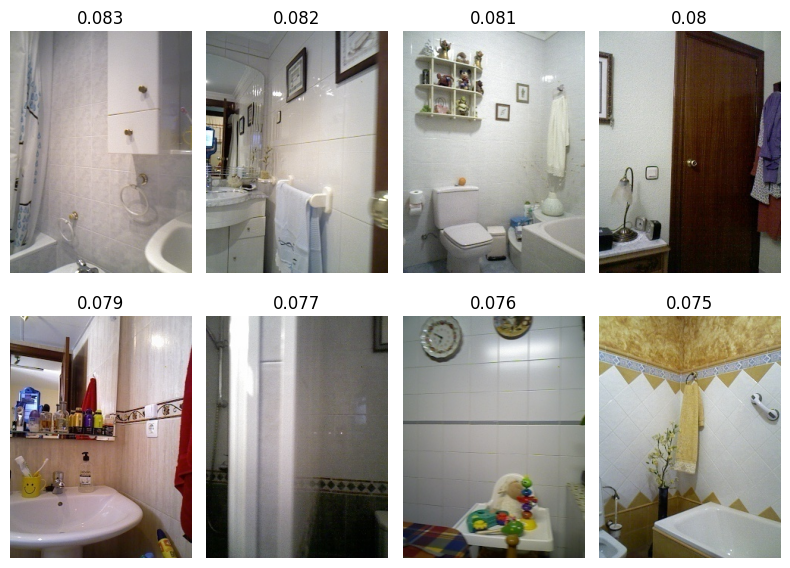

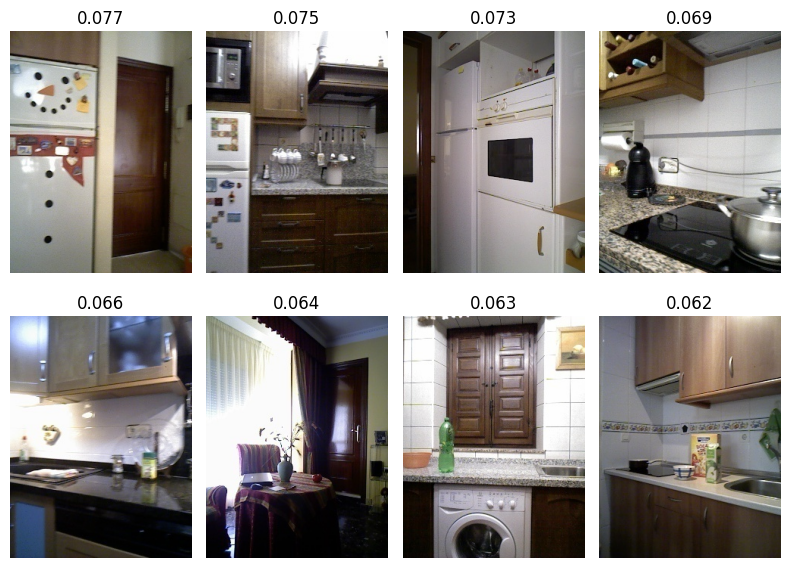

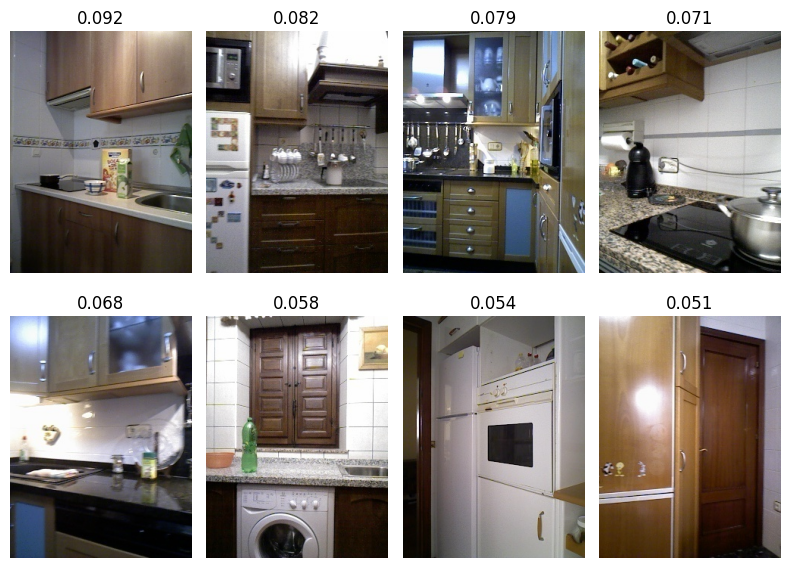

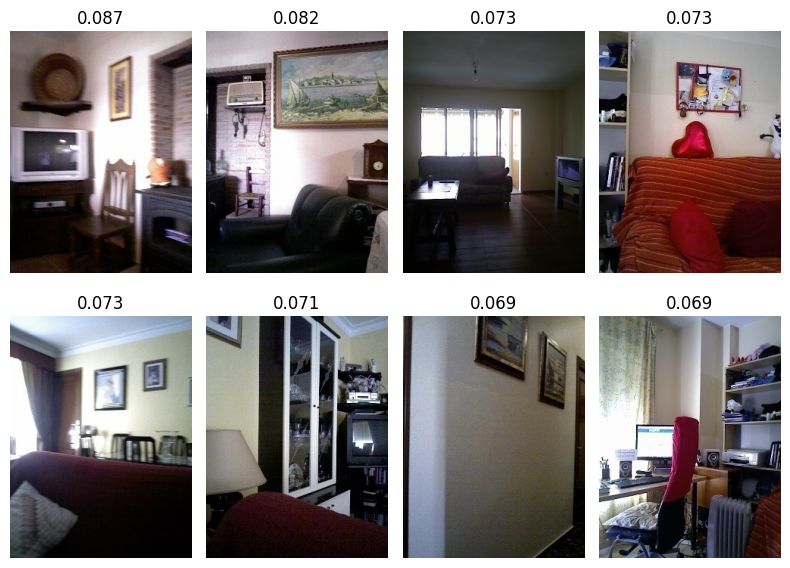

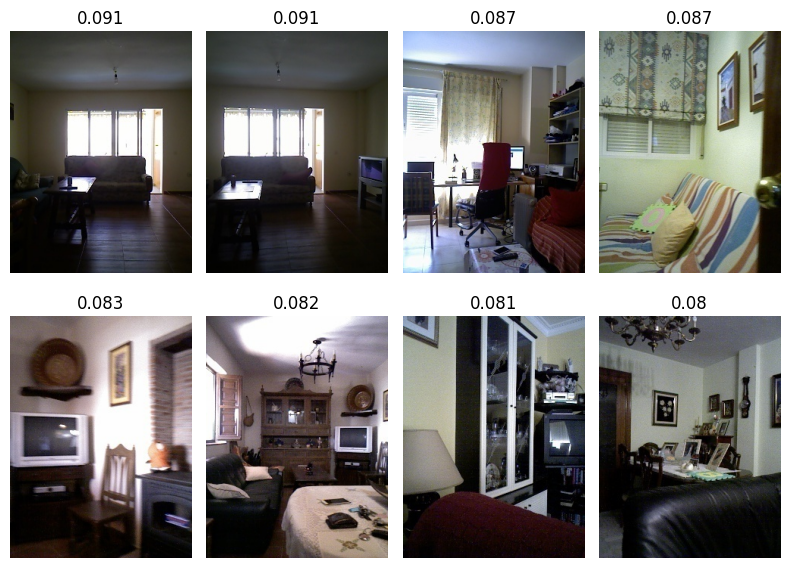

In [83]:
for l in labels_list:
    _df= df_s.sort_values(l, ascending=False)
    _df = _df.reset_index(drop=True)
    plt.figure(l, figsize=(8,6))
    for i in range(8):
        [img_f, _] = rh.get_RGBD_files(_df['id'][i])
        img = Image.open(img_f)
        plt.subplot(2,4,i+1)
        plt.imshow(img)
        plt.title(round(_df[l][i],3))
        plt.axis('off')
    plt.tight_layout()
plt.show()